In [261]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu


D:\Asus\Ungdung\Anacoda\Anacoda\envs\40daysPython_env\lib\site-packages\gdown\__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: d:\Asus\AIO\AIO-Exercise\module5\week3\Auto_MPG_data.csv

  0%|          | 0.00/15.4k [00:00<?, ?B/s]
100%|██████████| 15.4k/15.4k [00:00<00:00, 15.5MB/s]


In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Cài đặt giá trị ngẫu nhiên cố định:

In [263]:
random_state = 59
np.random.seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

### Cài đặt thiết bị tính toán:

In [264]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Đọc bộ dữ liệu:

In [265]:
data = pd.read_csv('./Auto_MPG_data.csv')
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Tiền xử lý bộ dữ liệu:

#### (a) Tách đặc trưng X và nhãn y:

In [266]:
X = data.drop(columns='MPG').values
y = data['MPG'].values

#### (b) Chia bộ dữ liệu train/val/test: 7:2:1

In [267]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, shuffle=is_shuffle, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=random_state)

#### (c) Chuẩn hóa đặc trưng đầu vào:

In [268]:
normalize = StandardScaler()

X_train = normalize.fit_transform(X_train)
X_val = normalize.transform(X_val)
X_test = normalize.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Xây dựng DataLoader:

Phải định nghĩa CustomDataset như dưới DataLoader mới hoạt động

In [269]:
class CustomDataset:
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, key):
        return (self.X[key], self.y[key])

In [270]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=is_shuffle)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=is_shuffle)

### Xây dựng mạng MLP:

In [271]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims) 

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        output = self.output(x)
        # Loại bỏ chiều dư thừa (chiều nào bằng 1 thì bỏ)
        return output.squeeze(1)
    

In [272]:
input_dims = X.shape[1]
output_dims = 1
hidden_dims = 64
model = MLP(input_dims,hidden_dims, output_dims).to(device=device)

### Khai báo hàm loss và optimizer:

In [273]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [274]:
total = 0
for params in model.parameters():
    total += params.numel()

total

4865

### Xây dựng hàm tính điểm R2:

In [275]:
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

### Huấn luyện mô hình:

chế độ model.train sẽ bật 2 cơ chế sau : 
- Dropout: một phương pháp regularization (điều chuẩn hóa) giúp ngăn chặn hiện tượng overfitting và co-adaptation of neurons (tức là khi các nơ-ron phụ thuộc quá nhiều vào nhau).
- BatchNorm: cải thiện hiệu quả huấn luyện và giảm hiện tượng "internal covariate shift"

link tham khảo :
- Dropout : https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout
- Batchnorm : https://pytorch.org/docs/stable/search.html?q=class%3A%60BatchNorm%60&check_keywords=yes&area=default


In [276]:
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()

    for x_b_train, y_b_train in train_loader:
        x_b_train = x_b_train.to(device)
        y_b_train = y_b_train.to(device)
        
        optimizer.zero_grad()
        y_b_predict = model(x_b_train)
        loss = criterion(y_b_predict, y_b_train)
        loss.backward()
        optimizer.step()

        train_predict.extend(y_b_predict.tolist())
        train_target.extend(y_b_train.tolist())


        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(y_true=train_target, y_pred=train_predict))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_b_val, y_b_val in val_loader:
            x_b_val = x_b_val.to(device)
            y_b_val = y_b_val.to(device)

            y_val_predict = model(x_b_val)
            loss = criterion(y_val_predict, y_b_val)
            val_loss += loss 

            val_predict.extend(y_val_predict.tolist())
            val_target.extend(y_b_val.tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss.item())
    val_r2.append(r_squared(y_true=val_target, y_pred=val_predict))

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

    


EPOCH 1:	Training loss: 380.393	Validation loss: 482.333

EPOCH 2:	Training loss: 194.040	Validation loss: 314.089

EPOCH 3:	Training loss: 180.480	Validation loss: 48.084

EPOCH 4:	Training loss: 20.673	Validation loss: 5.998

EPOCH 5:	Training loss: 20.314	Validation loss: 24.848

EPOCH 6:	Training loss: 17.868	Validation loss: 38.707

EPOCH 7:	Training loss: 34.559	Validation loss: 92.758

EPOCH 8:	Training loss: 21.122	Validation loss: 5.283

EPOCH 9:	Training loss: 10.710	Validation loss: 31.339

EPOCH 10:	Training loss: 20.777	Validation loss: 8.117

EPOCH 11:	Training loss: 8.785	Validation loss: 6.385

EPOCH 12:	Training loss: 20.409	Validation loss: 15.344

EPOCH 13:	Training loss: 11.720	Validation loss: 11.048

EPOCH 14:	Training loss: 11.641	Validation loss: 10.651

EPOCH 15:	Training loss: 8.094	Validation loss: 5.638

EPOCH 16:	Training loss: 8.462	Validation loss: 11.000

EPOCH 17:	Training loss: 12.126	Validation loss: 9.332

EPOCH 18:	Training loss: 7.317	Validation l

### Đánh giá mô hình:

In [277]:
model.eval()
with torch.no_grad():
    y_hat = model(X_test.to(device))
    test_set_r2 = r_squared(y_test, y_hat)

print('Evaluation on test set:')
print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.8699488639831543


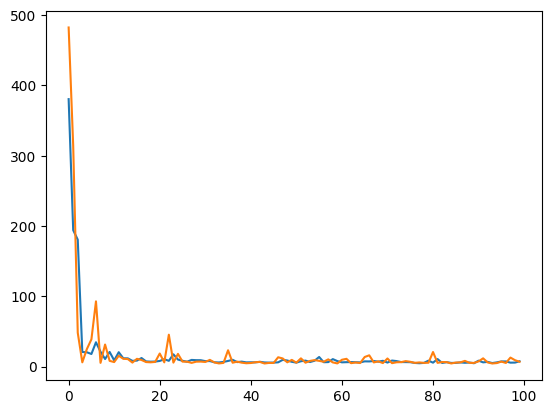

In [278]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), train_losses)
ax.plot(np.arange(epochs), val_losses)